# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path='datasets/lectures.txt', data_format='vowpal_wabbit',
                                        target_folder='datasets/lectures_batches')

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]

model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text': 1, 'author': 1})
model_artm.cache_theta = True

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
model_artm.scores.add(artm.TopTokensScore(name='text_top_words', class_id='text', num_tokens=15))
model_artm.scores.add(artm.TopTokensScore(name='author_top_words', class_id='author', num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(artm.regularizers.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=1e5, class_ids='text', 
                                                                         dictionary='dictionary', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.regularizers.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e5, class_ids='text', 
                                                                         dictionary='dictionary', 
                                                                         topic_names=topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
text_top_words = model_artm.score_tracker['text_top_words'].last_tokens
for topic in text_top_words:
    print(topic + ': ' + ' '.join(text_top_words[topic]))

sbj0: церковь русь средневековый император святой власть сага князь папа византийский поэзия церковный рим вера король
sbj1: планета земля атмосфера вода солнце солнечный белый карлик газ вокруг образовываться поверхность спутник радиус метр
sbj2: система трудность относительность тест задание преподавание отсчет системный научение компетенция адаптивный обществознание подготовка моделирование спиновый
sbj3: культура наука рассказывать понятие кандидат исторический каков доктор культурный сознание восприятие филологический феномен владимир личность
sbj4: право правовой римский юрист искусство суд юридический должник собственность обязательство договор владение собственник исполнение имущество
sbj5: материал свет оптический полимер применение импульс поверхность электронный использование лазерный углеродный прибор электроника бор трехмерный
sbj6: литература фильм текст литературный кино произведение автор герой жанр кинематограф поэт анекдот писатель читатель культовый
sbj7: смерть риту

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [13]:
sbj_topic_labels = ['История', 'Астрономия', 'Образование', 'Культура', 'Обществознание', 'Физика', 
                    'Литература и кино', 'Ритуал', 'Химия', 'Физика элементарных частиц', 'История России', 
                    'Семья', 'Биология', 'История и христианство', 'Астрофизика', 'Информатика в психологии',
                    'Антропология', 'Философия', 'Лингвистика', 'Революция', 'Город', 'Медицина', 'Социология', 
                    'Искусственный интеллект', 'История древнего мира', 'Фонетика', 'Экономика', 
                    'Молекулярная биология', 'Проводники и диэлектрики']
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [14]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta = model_artm.get_theta()
phi_a = model_artm.get_phi(class_ids='author')

In [15]:
phi_a.shape

(539, 30)

In [16]:
theta.shape

(30, 1728)

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

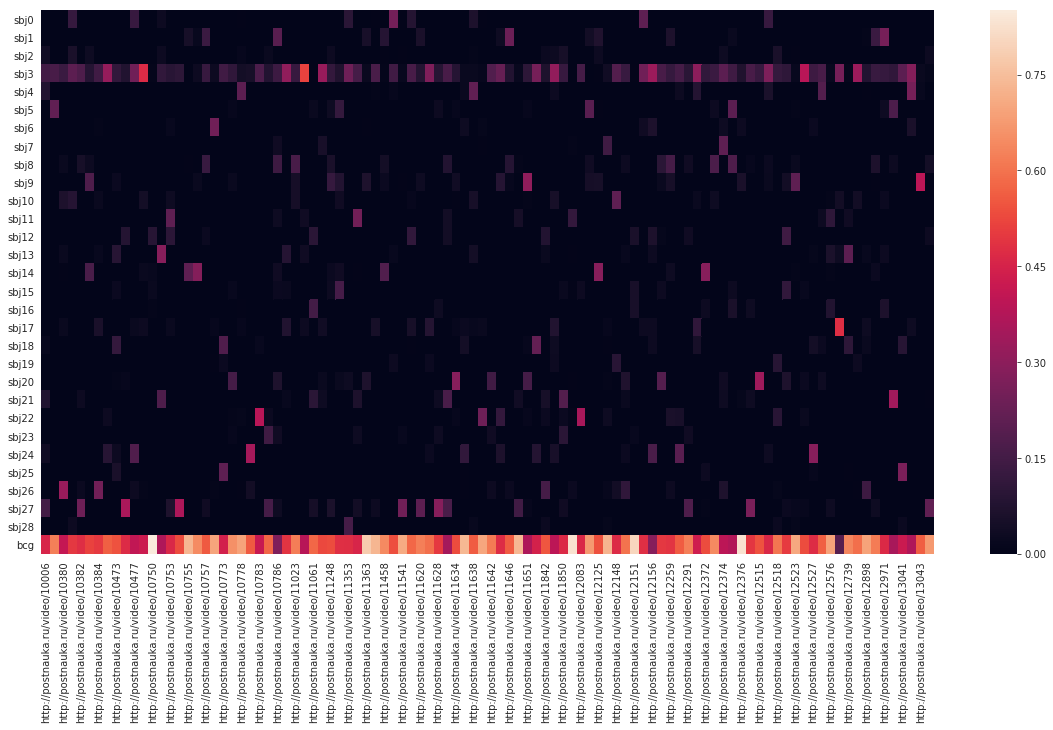

In [17]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:, :100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [18]:
# Ваш код
topic_prob = pd.DataFrame(index=topic_labels, columns=['Probability'])
topic_prob['Probability'] = theta.sum(axis=1).values
topic_prob['Probability'] /= topic_prob['Probability'].sum()
topic_prob

,Probability
История,0.010347
Астрономия,0.010862
Образование,0.005904
Культура,0.041272
Обществознание,0.007677
Физика,0.009932
Литература и кино,0.007143
Ритуал,0.003844
Химия,0.010774
Физика элементарных частиц,0.020953


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [19]:
topic_prob.sort_values(by='Probability')

,Probability
Ритуал,0.003844
Фонетика,0.003983
Проводники и диэлектрики,0.005235
Антропология,0.005792
Революция,0.005865
Образование,0.005904
Искусственный интеллект,0.005914
Литература и кино,0.007143
Семья,0.007338
Обществознание,0.007677


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

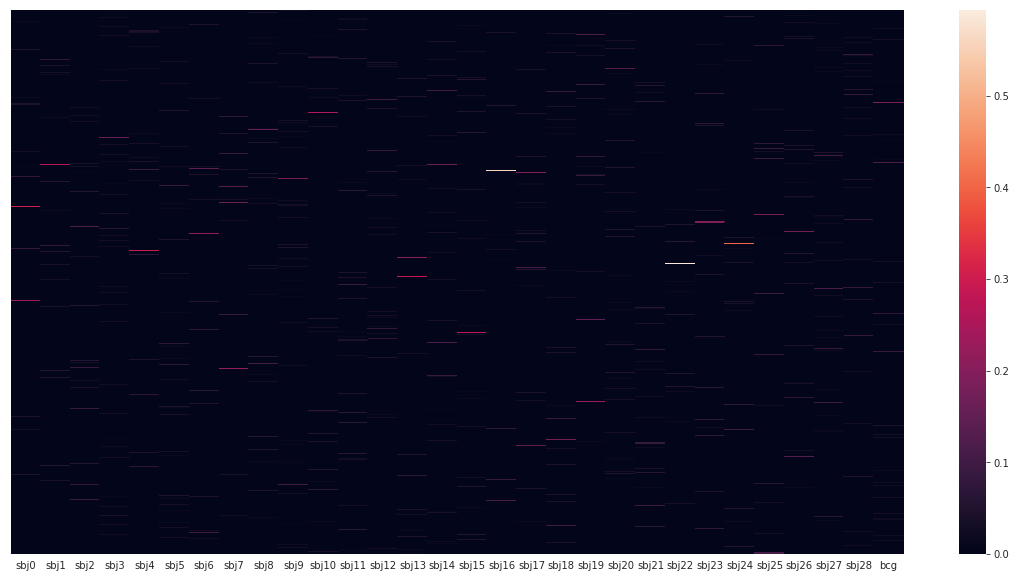

In [20]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [21]:
authors = (phi_a > 0.01).sum(axis=1)
authors[authors >= 3]

Илья_Иткин              3
Ольга_Тогоева           3
Алина_Бодрова           3
Ольга_Вайнштейн         5
Александр_Воеводский    3
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [22]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [23]:
profiles = phi_a.mul(topic_prob['Probability'].values, axis=1)
profiles = profiles.div(profiles.sum(axis=1).values, axis=0)

In [24]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
cos_distances = pairwise_distances(profiles, metric='cosine')
transformed_profiles = mds.fit_transform(cos_distances)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

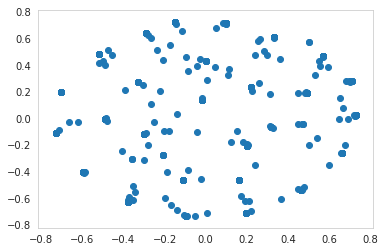

In [25]:
plt.scatter(transformed_profiles[:, 0], transformed_profiles[:, 1])
plt.show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

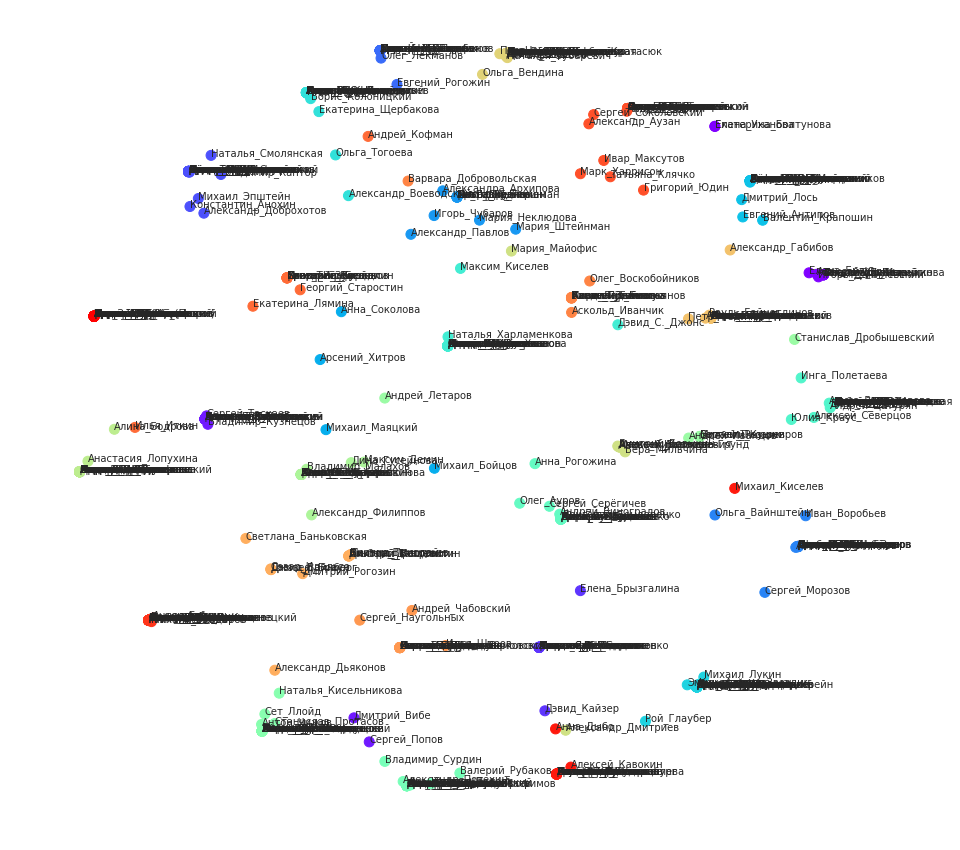

In [26]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
c = np.argmax(profiles.values, axis=1)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.scatter(transformed_profiles[:, 0], transformed_profiles[:, 1], c=colors[c], s=100)
for i, author in enumerate(profiles.index):
    plt.annotate(xy=transformed_profiles[i], s=author)
plt.savefig('authors_map.pdf', format='pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [27]:
pdt = theta.div(theta.sum(axis=1), axis=0)
pdt.index = topic_labels
pdt.head()

,http://postnauka.ru/video/10006,http://postnauka.ru/video/10379,http://postnauka.ru/video/10380,http://postnauka.ru/video/10381,http://postnauka.ru/video/10382,http://postnauka.ru/video/10383,http://postnauka.ru/video/10384,http://postnauka.ru/video/10385,http://postnauka.ru/video/10473,http://postnauka.ru/video/10475,...,http://postnauka.ru/video/9874,http://postnauka.ru/video/9876,http://postnauka.ru/video/9968,http://postnauka.ru/video/9992,http://postnauka.ru/video/9993,http://postnauka.ru/video/9994,http://postnauka.ru/video/9995,http://postnauka.ru/video/9996,http://postnauka.ru/video/9997,http://postnauka.ru/video/9998
История,0.000000,0.00000,0.000000e+00,0.006845,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.019769,0.001018,0.000000,0.000000e+00,5.150954e-08,0.000000e+00,0.000000,0.000000
Астрономия,0.000000,0.00000,1.203452e-13,0.000000,0.000000,0.000000,9.461594e-13,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000167,8.702103e-13,1.500746e-03,0.000000e+00,0.000000,0.000000
Образование,0.003615,0.00000,0.000000e+00,0.005776,0.000000,0.003022,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,3.028190e-10,0.000000,0.000000
Культура,0.002061,0.00228,1.852024e-03,0.002855,0.002466,0.001187,2.018927e-03,0.004447,0.001557,0.001071,...,0.002512,0.002056,0.002187,0.001659,0.000021,2.126954e-03,5.386653e-05,1.154192e-03,0.003058,0.001779
Обществознание,0.005783,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000261,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000


In [28]:
# relevant_docs = [docs[1:][0].sort_values(ascending=False)[:10].index for docs in pdt.iterrows()]
relevant_docs = [(docs[0], docs[1].sort_values(ascending=False)) for docs in pdt.iterrows()]

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [29]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [30]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [34]:
top_words = model_artm.score_tracker['text_top_words'].last_tokens
for (topic_name, docs), topic_id in zip(relevant_docs[:-1], model_artm.topic_names[:-1]):
    display(HTML('<h1>' + topic_name + '</h1>'))   
    display(HTML(' '.join(text_top_words[topic_id][:10]))) 
    for link in docs[:10].index:
        print(link)
    

http://postnauka.ru/video/3348
http://postnauka.ru/video/24034
http://postnauka.ru/video/9968
http://postnauka.ru/video/9299
http://postnauka.ru/video/24039
http://postnauka.ru/video/24030
http://postnauka.ru/video/28942
http://postnauka.ru/video/23472
http://postnauka.ru/video/50350
http://postnauka.ru/video/5464


http://postnauka.ru/video/53693
http://postnauka.ru/video/24245
http://postnauka.ru/video/32889
http://postnauka.ru/video/9835
http://postnauka.ru/video/31695
http://postnauka.ru/video/13098
http://postnauka.ru/video/12971
http://postnauka.ru/video/49261
http://postnauka.ru/video/36249
http://postnauka.ru/video/3381


http://postnauka.ru/video/46317
http://postnauka.ru/video/34426
http://postnauka.ru/video/1856
http://postnauka.ru/video/50347
http://postnauka.ru/video/37982
http://postnauka.ru/video/19570
http://postnauka.ru/video/53415
http://postnauka.ru/video/56618
http://postnauka.ru/video/47457
http://postnauka.ru/video/52548


http://postnauka.ru/video/11034
http://postnauka.ru/video/10749
http://postnauka.ru/video/7549
http://postnauka.ru/video/5891
http://postnauka.ru/video/3602
http://postnauka.ru/video/7757
http://postnauka.ru/video/12524
http://postnauka.ru/video/7351
http://postnauka.ru/video/7065
http://postnauka.ru/video/2524


http://postnauka.ru/video/17913
http://postnauka.ru/video/31688
http://postnauka.ru/video/17825
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/42221
http://postnauka.ru/video/31666
http://postnauka.ru/video/16822
http://postnauka.ru/video/42220


http://postnauka.ru/video/35065
http://postnauka.ru/video/36187
http://postnauka.ru/video/36655
http://postnauka.ru/video/59579
http://postnauka.ru/video/41686
http://postnauka.ru/video/47818
http://postnauka.ru/video/31182
http://postnauka.ru/video/9144
http://postnauka.ru/video/10379
http://postnauka.ru/video/36490


http://postnauka.ru/video/14297
http://postnauka.ru/video/39723
http://postnauka.ru/video/7551
http://postnauka.ru/video/10759
http://postnauka.ru/video/2946
http://postnauka.ru/video/57127
http://postnauka.ru/video/13541
http://postnauka.ru/video/52416
http://postnauka.ru/video/38510
http://postnauka.ru/video/42807


http://postnauka.ru/video/1893
http://postnauka.ru/video/1899
http://postnauka.ru/video/12374
http://postnauka.ru/video/34963
http://postnauka.ru/video/41680
http://postnauka.ru/video/19472
http://postnauka.ru/video/37958
http://postnauka.ru/video/48480
http://postnauka.ru/video/37992
http://postnauka.ru/video/32882


http://postnauka.ru/video/8953
http://postnauka.ru/video/48107
http://postnauka.ru/video/18048
http://postnauka.ru/video/51490
http://postnauka.ru/video/32668
http://postnauka.ru/video/13700
http://postnauka.ru/video/19086
http://postnauka.ru/video/16171
http://postnauka.ru/video/23253
http://postnauka.ru/video/3645


http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/22760
http://postnauka.ru/video/2945
http://postnauka.ru/video/18873
http://postnauka.ru/video/14283
http://postnauka.ru/video/7753
http://postnauka.ru/video/7311
http://postnauka.ru/video/19457
http://postnauka.ru/video/11651


http://postnauka.ru/video/19574
http://postnauka.ru/video/46939
http://postnauka.ru/video/25906
http://postnauka.ru/video/31183
http://postnauka.ru/video/35041
http://postnauka.ru/video/36246
http://postnauka.ru/video/34936
http://postnauka.ru/video/25283
http://postnauka.ru/video/52936
http://postnauka.ru/video/36581


http://postnauka.ru/video/22892
http://postnauka.ru/video/11361
http://postnauka.ru/video/30678
http://postnauka.ru/video/10753
http://postnauka.ru/video/59638
http://postnauka.ru/video/31220
http://postnauka.ru/video/60527
http://postnauka.ru/video/52948
http://postnauka.ru/video/40266
http://postnauka.ru/video/57866


http://postnauka.ru/video/25097
http://postnauka.ru/video/34413
http://postnauka.ru/video/16821
http://postnauka.ru/video/18007
http://postnauka.ru/video/25890
http://postnauka.ru/video/30261
http://postnauka.ru/video/36350
http://postnauka.ru/video/25321
http://postnauka.ru/video/22077
http://postnauka.ru/video/23172


http://postnauka.ru/video/53171
http://postnauka.ru/video/2527
http://postnauka.ru/video/50071
http://postnauka.ru/video/59201
http://postnauka.ru/video/58742
http://postnauka.ru/video/50066
http://postnauka.ru/video/49203
http://postnauka.ru/video/48959
http://postnauka.ru/video/10751
http://postnauka.ru/video/46313


http://postnauka.ru/video/31193
http://postnauka.ru/video/17780
http://postnauka.ru/video/2971
http://postnauka.ru/video/45644
http://postnauka.ru/video/48109
http://postnauka.ru/video/30015
http://postnauka.ru/video/57338
http://postnauka.ru/video/17779
http://postnauka.ru/video/23506
http://postnauka.ru/video/23502


http://postnauka.ru/video/56052
http://postnauka.ru/video/24451
http://postnauka.ru/video/24182
http://postnauka.ru/video/5181
http://postnauka.ru/video/26633
http://postnauka.ru/video/57336
http://postnauka.ru/video/53949
http://postnauka.ru/video/19577
http://postnauka.ru/video/17421
http://postnauka.ru/video/34960


http://postnauka.ru/video/17397
http://postnauka.ru/video/31707
http://postnauka.ru/video/37732
http://postnauka.ru/video/49262
http://postnauka.ru/video/32898
http://postnauka.ru/video/42735
http://postnauka.ru/video/42707
http://postnauka.ru/video/35150
http://postnauka.ru/video/40880
http://postnauka.ru/video/36253


http://postnauka.ru/video/12738
http://postnauka.ru/video/3418
http://postnauka.ru/video/32906
http://postnauka.ru/video/37965
http://postnauka.ru/video/53513
http://postnauka.ru/video/42088
http://postnauka.ru/video/2526
http://postnauka.ru/video/36976
http://postnauka.ru/video/9728
http://postnauka.ru/video/31690


http://postnauka.ru/video/22433
http://postnauka.ru/video/36272
http://postnauka.ru/video/3403
http://postnauka.ru/video/2961
http://postnauka.ru/video/1898
http://postnauka.ru/video/51374
http://postnauka.ru/video/53644
http://postnauka.ru/video/56616
http://postnauka.ru/video/30017
http://postnauka.ru/video/51499


http://postnauka.ru/video/24279
http://postnauka.ru/video/48492
http://postnauka.ru/video/40004
http://postnauka.ru/video/47823
http://postnauka.ru/video/43843
http://postnauka.ru/video/54175
http://postnauka.ru/video/48455
http://postnauka.ru/video/58542
http://postnauka.ru/video/22079
http://postnauka.ru/video/23470


http://postnauka.ru/video/13742
http://postnauka.ru/video/12515
http://postnauka.ru/video/11634
http://postnauka.ru/video/34424
http://postnauka.ru/video/9998
http://postnauka.ru/video/7068
http://postnauka.ru/video/17604
http://postnauka.ru/video/47301
http://postnauka.ru/video/8313
http://postnauka.ru/video/25253


http://postnauka.ru/video/2541
http://postnauka.ru/video/54325
http://postnauka.ru/video/12974
http://postnauka.ru/video/49206
http://postnauka.ru/video/13746
http://postnauka.ru/video/45961
http://postnauka.ru/video/532
http://postnauka.ru/video/51384
http://postnauka.ru/video/27925
http://postnauka.ru/video/17049


http://postnauka.ru/video/10783
http://postnauka.ru/video/434
http://postnauka.ru/video/12083
http://postnauka.ru/video/17491
http://postnauka.ru/video/6380
http://postnauka.ru/video/20720
http://postnauka.ru/video/2530
http://postnauka.ru/video/3628
http://postnauka.ru/video/11640
http://postnauka.ru/video/14295


http://postnauka.ru/video/31671
http://postnauka.ru/video/2531
http://postnauka.ru/video/49437
http://postnauka.ru/video/42416
http://postnauka.ru/video/15981
http://postnauka.ru/video/52738
http://postnauka.ru/video/33788
http://postnauka.ru/video/3352
http://postnauka.ru/video/34964
http://postnauka.ru/video/38018


http://postnauka.ru/video/10779
http://postnauka.ru/video/9997
http://postnauka.ru/video/12527
http://postnauka.ru/video/21631
http://postnauka.ru/video/43664
http://postnauka.ru/video/31580
http://postnauka.ru/video/5999
http://postnauka.ru/video/46429
http://postnauka.ru/video/54238
http://postnauka.ru/video/42796


http://postnauka.ru/video/48114
http://postnauka.ru/video/13041
http://postnauka.ru/video/51171
http://postnauka.ru/video/8964
http://postnauka.ru/video/15341
http://postnauka.ru/video/10773
http://postnauka.ru/video/40001
http://postnauka.ru/video/14284
http://postnauka.ru/video/27944
http://postnauka.ru/video/15343


http://postnauka.ru/video/9389
http://postnauka.ru/video/7781
http://postnauka.ru/video/31684
http://postnauka.ru/video/10380
http://postnauka.ru/video/6758
http://postnauka.ru/video/13152
http://postnauka.ru/video/30601
http://postnauka.ru/video/36242
http://postnauka.ru/video/9429
http://postnauka.ru/video/26616


http://postnauka.ru/video/7113
http://postnauka.ru/video/5915
http://postnauka.ru/video/5390
http://postnauka.ru/video/19436
http://postnauka.ru/video/10754
http://postnauka.ru/video/10475
http://postnauka.ru/video/17051
http://postnauka.ru/video/35051
http://postnauka.ru/video/9854
http://postnauka.ru/video/32881


http://postnauka.ru/video/2973
http://postnauka.ru/video/49448
http://postnauka.ru/video/51380
http://postnauka.ru/video/50340
http://postnauka.ru/video/31198
http://postnauka.ru/video/55756
http://postnauka.ru/video/51174
http://postnauka.ru/video/50699
http://postnauka.ru/video/19461
http://postnauka.ru/video/40889


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 